In [2]:
import sklearn
import torch
import transformers
import peft
import tqdm
import math
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict, load_dataset
from transformers import AutoTokenizer, AutoModelForMaskedLM, DataCollatorWithPadding, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, roc_auc_score, roc_curve, auc
from peft import LoraConfig, TaskType, get_peft_model, IA3Config

## Load Models

In [3]:
tokenizer = AutoTokenizer.from_pretrained("gagneurlab/SpeciesLM", revision="downstream_species_lm")
lm = AutoModelForMaskedLM.from_pretrained("gagneurlab/SpeciesLM", revision="downstream_species_lm")

device = "cuda" if torch.cuda.is_available() else "cpu"
lm.eval()
lm.to(device)
print(f"Load pretrained model to device {device}")

Load pretrained model to device cuda


In [45]:
lm

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(5504, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

## Prepare Dataset

In [4]:
dataset = load_dataset(path="InstaDeepAI/nucleotide_transformer_downstream_tasks", 
                        name="enhancers", trust_remote_code=True)
dataset

DatasetDict({
    train: Dataset({
        features: ['sequence', 'name', 'label'],
        num_rows: 14968
    })
    test: Dataset({
        features: ['sequence', 'name', 'label'],
        num_rows: 400
    })
})

In [35]:
dataset['train'][0]

{'sequence': 'CAGTCACATCTGTAATCACAATACGTTGGGAGGCTGAGGCAGGAGGATCACTTGAGTCCAGGAGTTGAGGCTGCAGTGAGCTGTGATCACACCACTGCACTCTAGTGTGGGTGACAGTGAGACCCTGTCTCAAAAAAAAAAAAAAAAAGATACATTCAAAGAAGTCAAAATAAAACAGTATAAAACCTATCTCCCTGATT',
 'name': '***|0',
 'label': 0}

In [5]:
train_valid_split = dataset['train'].train_test_split(test_size=0.15, seed=42)

train_valid_split = DatasetDict({
    'train': train_valid_split['train'],
    'validation': train_valid_split['test']
})

ds = DatasetDict({
    'train': train_valid_split['train'],
    'validation': train_valid_split['validation'],
    'test': dataset['test']
})

In [6]:
def get_kmers(seq, k=6, stride=1):
    return [seq[i:i + k] for i in range(0, len(seq), stride) if i + k <= len(seq)]

In [7]:
def get_dataset(ds):
    test_sequences = []
    train_sequences = []
    val_sequences = []
    
    for i in range(0, len(ds['train'])):
    
        sequence = ds['train'][i]['sequence']
        sequence = "candida_glabrata " + " ".join(get_kmers(sequence))
        sequence = tokenizer(sequence)["input_ids"]
        train_sequences.append(sequence)
    
    for i in range(0, len(ds['validation'])):
        sequence = ds['validation'][i]['sequence']
        sequence = "candida_glabrata " + " ".join(get_kmers(sequence))
        sequence = tokenizer(sequence)["input_ids"]
        val_sequences.append(sequence)
    
    
    for i in range(0, len(ds['test'])):
        sequence = ds['test'][i]['sequence']
        sequence = "candida_glabrata " + " ".join(get_kmers(sequence))
        sequence = tokenizer(sequence)["input_ids"]
        test_sequences.append(sequence)
    
    
    train_labels = ds['train']['label']
    test_labels = ds['test']['label']
    val_labels = ds['validation']['label']
    
    a = {"input_ids": train_sequences, "labels": train_labels}
    df = pd.DataFrame.from_dict(a)
    train_dataset = Dataset.from_pandas(df)
    
    b = {"input_ids": val_sequences, "labels": val_labels}
    df = pd.DataFrame.from_dict(b)
    val_dataset = Dataset.from_pandas(df)
    
    c = {"input_ids": test_sequences, "labels": test_labels}
    df = pd.DataFrame.from_dict(c)
    test_dataset = Dataset.from_pandas(df)
    
    total = len(train_dataset)+len(val_dataset)+len(test_dataset)
    
    print(f"""# of Train set: {len(train_dataset)} ({round(len(train_dataset)/total,2)})
    # of Validation set: {len(val_dataset)} ({round(len(val_dataset)/total,2)})
    # of Test set: {len(test_dataset)}({round(len(test_dataset)/total,2)})""")
    return train_dataset, val_dataset, test_dataset, train_labels, val_labels, test_labels


In [8]:
train_dataset, val_dataset, test_dataset, train_labels, val_labels, test_labels = get_dataset(ds)

# of Train set: 12722 (0.83)
    # of Validation set: 2246 (0.15)
    # of Test set: 400(0.03)


## Set Up Model

In [9]:
# free model weights
for param in lm.parameters():
  param.requires_grad = False

In [10]:
class DNA_LM(nn.Module):
    def __init__(self, model, num_labels):
        super(DNA_LM, self).__init__()
        self.model = model.bert  # take only the encoder
        self.in_features = self.model.config.hidden_size
        self.out_features = num_labels
        self.classifier = nn.Linear(self.in_features, self.out_features)

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.model(input_ids=input_ids,
                             attention_mask=attention_mask,
                             output_hidden_states=True)
        sequence_output = outputs.last_hidden_state
        # Use the [CLS] token for classification
        cls_output = sequence_output[:, 0, :]
        logits = self.classifier(cls_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.out_features), labels.view(-1))

        return (loss, logits) if loss is not None else logits

num_labels = 2

In [11]:
# Number of classes for your classification task

batch_size = 128
num_labels = 2
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
epochs = 5
weight_decay = 1e-2
learning_rate = 1e-3

In [28]:
baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/baseline',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=baseline_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.115200,0.254499
2,0.245100,0.242373
3,0.063300,0.245992
4,0.056600,0.249173
5,0.133800,0.248486


TrainOutput(global_step=500, training_loss=0.154681812569499, metrics={'train_runtime': 502.8833, 'train_samples_per_second': 126.491, 'train_steps_per_second': 0.994, 'total_flos': 0.0, 'train_loss': 0.154681812569499, 'epoch': 5.0})

In [30]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.221100,0.279854
2,0.378500,0.275514
3,0.155100,0.285330
4,0.226500,0.270949
5,0.275300,0.271846


TrainOutput(global_step=500, training_loss=0.2981044951081276, metrics={'train_runtime': 276.2816, 'train_samples_per_second': 230.236, 'train_steps_per_second': 1.81, 'total_flos': 0.0, 'train_loss': 0.2981044951081276, 'epoch': 5.0})

## Predict using baseline model

In [14]:
def sklearn_eval(test_labels, predicted_labels):
    accuracy = accuracy_score(test_labels, predicted_labels)
    print(f"Accuracy: {accuracy:.4f}")
    
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='weighted')
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    roc_score = roc_auc_score(test_labels, predicted_labels)
    print(f"AUC ROC score: {roc_score:.4f}")

    target_names = ['Class 0', 'Class 1']
    print(classification_report(test_labels, predicted_labels, target_names=target_names))

In [16]:
def plot_roc(test_labels, predicted_labels):
  fpr, tpr, thresholds = roc_curve(test_labels, predicted_labels, pos_label = 1)

  # AUC score that summarizes the ROC curve
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr, tpr, lw = 2, label = 'ROC AUC: {:.2f}'.format(roc_auc))
  plt.plot([0, 1], [0, 1],
          linestyle = '--',
          color = (0.6, 0.6, 0.6),
          label = 'random guessing')
  plt.plot([0, 0, 1], [0, 1, 1],
          linestyle = ':',
          color = 'black', 
          label = 'perfect performance')

  plt.xlim([-0.05, 1.05])
  plt.ylim([-0.05, 1.05])
  plt.xlabel('false positive rate')
  plt.ylabel('true positive rate')
  plt.title('Receiver Operator Characteristic')
  plt.legend(loc = "lower right")
  plt.tight_layout()
  plt.show()

In [29]:
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
predicted_labels_baseline = logits.argmax(axis=-1)

In [30]:
sklearn_eval(test_labels, predicted_labels_baseline)

Accuracy: 0.7250
Precision: 0.7283
Recall: 0.7250
F1-Score: 0.7240
AUC ROC score: 0.7250
              precision    recall  f1-score   support

     Class 0       0.76      0.67      0.71       200
     Class 1       0.70      0.79      0.74       200

    accuracy                           0.72       400
   macro avg       0.73      0.73      0.72       400
weighted avg       0.73      0.72      0.72       400



## Finetune pre-trained model for Downstream Task

### Lora rank=2

In [17]:
lora_config = LoraConfig(
    #task_type="SEQ_CLS",
    r=2,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    lora_dropout=0.01,
)

baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)
lora_model = get_peft_model(baseline_model, lora_config)
lora_model.print_trainable_parameters()

trainable params: 110,592 || all params: 89,789,954 || trainable%: 0.1232


In [35]:
lora_model

PeftModel(
  (base_model): LoraModel(
    (model): DNA_LM(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(5504, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.01, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=4, bias

In [18]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/lora',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.189400,No log
2,0.304700,No log
3,0.169700,No log
4,0.190100,No log
5,0.213400,No log


TrainOutput(global_step=500, training_loss=0.23760190151631833, metrics={'train_runtime': 399.3336, 'train_samples_per_second': 159.29, 'train_steps_per_second': 1.252, 'total_flos': 0.0, 'train_loss': 0.23760190151631833, 'epoch': 5.0})

In [20]:
predictions = trainer.predict(test_dataset)
loss, logits = predictions.predictions
predicted_labels_lora2 = logits.argmax(axis=-1)

sklearn_eval(test_labels, predicted_labels)

Accuracy: 0.7200
Precision: 0.7232
Recall: 0.7200
F1-Score: 0.7190
AUC ROC score: 0.7200
              precision    recall  f1-score   support

     Class 0       0.75      0.66      0.70       200
     Class 1       0.70      0.78      0.74       200

    accuracy                           0.72       400
   macro avg       0.72      0.72      0.72       400
weighted avg       0.72      0.72      0.72       400



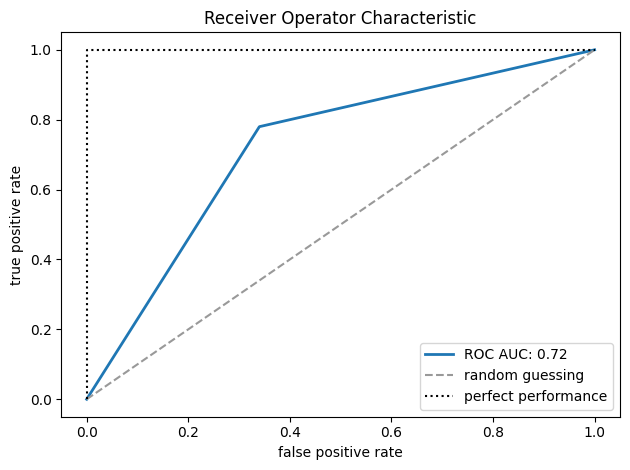

In [21]:
plot_roc(test_labels, predicted_labels)

### LoRA rank=4

In [34]:
lora_config = LoraConfig(
    #task_type="SEQ_CLS",
    r=4,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    lora_dropout=0.01,
)

baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)
lora_model = get_peft_model(baseline_model, lora_config)
lora_model.print_trainable_parameters()

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/lora',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


trainable params: 248,832 || all params: 89,928,194 || trainable%: 0.2767


Epoch,Training Loss,Validation Loss
1,0.186400,No log
2,0.286000,No log
3,0.156000,No log
4,0.157700,No log
5,0.193600,No log


TrainOutput(global_step=500, training_loss=0.24424503695964814, metrics={'train_runtime': 400.1887, 'train_samples_per_second': 158.95, 'train_steps_per_second': 1.249, 'total_flos': 0.0, 'train_loss': 0.24424503695964814, 'epoch': 5.0})

In [35]:
predictions = trainer.predict(test_dataset)
loss, logits = predictions.predictions
predicted_labels_lora4 = logits.argmax(axis=-1)

sklearn_eval(test_labels, predicted_labels_lora4)

Accuracy: 0.7400
Precision: 0.7448
Recall: 0.7400
F1-Score: 0.7387
AUC ROC score: 0.7400
              precision    recall  f1-score   support

     Class 0       0.78      0.67      0.72       200
     Class 1       0.71      0.81      0.76       200

    accuracy                           0.74       400
   macro avg       0.74      0.74      0.74       400
weighted avg       0.74      0.74      0.74       400



### LoRA r=16

In [12]:
lora_config = LoraConfig(
    #task_type="SEQ_CLS",
    r=16,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    lora_dropout=0.01,
)

baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)
lora_model = get_peft_model(baseline_model, lora_config)
lora_model.print_trainable_parameters()

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/lora',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


trainable params: 884,736 || all params: 90,564,098 || trainable%: 0.9769


Epoch,Training Loss,Validation Loss
1,0.182800,No log
2,0.283100,No log
3,0.115100,No log
4,0.161800,No log
5,0.165600,No log


TrainOutput(global_step=500, training_loss=0.2331137022227049, metrics={'train_runtime': 403.2821, 'train_samples_per_second': 157.731, 'train_steps_per_second': 1.24, 'total_flos': 0.0, 'train_loss': 0.2331137022227049, 'epoch': 5.0})

In [15]:
predictions = trainer.predict(test_dataset)
loss, logits = predictions.predictions
predicted_labels_lora16 = logits.argmax(axis=-1)

sklearn_eval(test_labels, predicted_labels_lora16)

Accuracy: 0.7350
Precision: 0.7358
Recall: 0.7350
F1-Score: 0.7348
AUC ROC score: 0.7350
              precision    recall  f1-score   support

     Class 0       0.75      0.70      0.73       200
     Class 1       0.72      0.77      0.74       200

    accuracy                           0.73       400
   macro avg       0.74      0.73      0.73       400
weighted avg       0.74      0.73      0.73       400



### LoRA r=32

In [16]:
lora_config = LoraConfig(
    #task_type="SEQ_CLS",
    r=32,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    lora_dropout=0.01,
)

baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)
lora_model = get_peft_model(baseline_model, lora_config)
lora_model.print_trainable_parameters()

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/lora',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


trainable params: 1,769,472 || all params: 91,448,834 || trainable%: 1.9349


Epoch,Training Loss,Validation Loss
1,0.197500,No log
2,0.292800,No log
3,0.179200,No log
4,0.194700,No log
5,0.226500,No log


TrainOutput(global_step=500, training_loss=0.23078642888367176, metrics={'train_runtime': 402.1559, 'train_samples_per_second': 158.172, 'train_steps_per_second': 1.243, 'total_flos': 0.0, 'train_loss': 0.23078642888367176, 'epoch': 5.0})

In [17]:
predictions = trainer.predict(test_dataset)
loss, logits = predictions.predictions
predicted_labels_lora32 = logits.argmax(axis=-1)

sklearn_eval(test_labels, predicted_labels_lora32)

Accuracy: 0.7200
Precision: 0.7222
Recall: 0.7200
F1-Score: 0.7193
AUC ROC score: 0.7200
              precision    recall  f1-score   support

     Class 0       0.74      0.67      0.71       200
     Class 1       0.70      0.77      0.73       200

    accuracy                           0.72       400
   macro avg       0.72      0.72      0.72       400
weighted avg       0.72      0.72      0.72       400



## Dora Model
### DoRA rank=4

In [36]:
dora_config = LoraConfig(
    #task_type="SEQ_CLS",
    use_dora=True,
    r=4,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    lora_dropout=0.01,
)
baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)
dora_model = get_peft_model(baseline_model, dora_config)
dora_model.print_trainable_parameters()

trainable params: 248,832 || all params: 89,928,194 || trainable%: 0.2767


In [37]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/dora',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=dora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [38]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.178500,No log
2,0.270300,No log
3,0.196000,No log
4,0.221300,No log
5,0.181700,No log


TrainOutput(global_step=500, training_loss=0.24455363492667676, metrics={'train_runtime': 499.2619, 'train_samples_per_second': 127.408, 'train_steps_per_second': 1.001, 'total_flos': 0.0, 'train_loss': 0.24455363492667676, 'epoch': 5.0})

In [39]:
predictions = trainer.predict(test_dataset)
loss, logits = predictions.predictions
predicted_labels_dora4 = logits.argmax(axis=-1)

sklearn_eval(test_labels, predicted_labels_dora4)

Accuracy: 0.7375
Precision: 0.7433
Recall: 0.7375
F1-Score: 0.7359
AUC ROC score: 0.7375
              precision    recall  f1-score   support

     Class 0       0.78      0.66      0.72       200
     Class 1       0.71      0.81      0.76       200

    accuracy                           0.74       400
   macro avg       0.74      0.74      0.74       400
weighted avg       0.74      0.74      0.74       400



### RoRA rank=2

In [24]:
dora_config = LoraConfig(
    #task_type="SEQ_CLS",
    use_dora=True,
    r=2,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    lora_dropout=0.01,
)
baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)
dora_model = get_peft_model(baseline_model, dora_config)
dora_model.print_trainable_parameters()

trainable params: 138,240 || all params: 89,817,602 || trainable%: 0.1539


In [25]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/dora',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=dora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
print(f'Dora Rank: {rank}')
trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Dora Rank: 2


Epoch,Training Loss,Validation Loss
1,0.189500,No log
2,0.339600,No log
3,0.192200,No log
4,0.167000,No log
5,0.175900,No log


TrainOutput(global_step=500, training_loss=0.2508829207718372, metrics={'train_runtime': 502.0099, 'train_samples_per_second': 126.711, 'train_steps_per_second': 0.996, 'total_flos': 0.0, 'train_loss': 0.2508829207718372, 'epoch': 5.0})

In [26]:
predictions = trainer.predict(test_dataset)
loss, logits = predictions.predictions
predicted_labels_dora_2 = logits.argmax(axis=-1)

sklearn_eval(test_labels, predicted_labels_dora_2)

Accuracy: 0.7525
Precision: 0.7587
Recall: 0.7525
F1-Score: 0.7510
AUC ROC score: 0.7525
              precision    recall  f1-score   support

     Class 0       0.80      0.68      0.73       200
     Class 1       0.72      0.83      0.77       200

    accuracy                           0.75       400
   macro avg       0.76      0.75      0.75       400
weighted avg       0.76      0.75      0.75       400



### DoRA r=16

In [18]:
dora_config = LoraConfig(
    #task_type="SEQ_CLS",
    use_dora=True,
    r=16,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    lora_dropout=0.01,
)
baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)
dora_model = get_peft_model(baseline_model, dora_config)
dora_model.print_trainable_parameters()

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/dora',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=dora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
trainer.train()

trainable params: 912,384 || all params: 90,591,746 || trainable%: 1.0071


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.173600,No log
2,0.311600,No log
3,0.192100,No log
4,0.252600,No log
5,0.203300,No log


TrainOutput(global_step=500, training_loss=0.24431000630557537, metrics={'train_runtime': 502.6391, 'train_samples_per_second': 126.552, 'train_steps_per_second': 0.995, 'total_flos': 0.0, 'train_loss': 0.24431000630557537, 'epoch': 5.0})

In [19]:
predictions = trainer.predict(test_dataset)
loss, logits = predictions.predictions
predicted_labels_dora_16 = logits.argmax(axis=-1)

sklearn_eval(test_labels, predicted_labels_dora_16)

Accuracy: 0.7250
Precision: 0.7289
Recall: 0.7250
F1-Score: 0.7238
AUC ROC score: 0.7250
              precision    recall  f1-score   support

     Class 0       0.76      0.66      0.71       200
     Class 1       0.70      0.79      0.74       200

    accuracy                           0.72       400
   macro avg       0.73      0.73      0.72       400
weighted avg       0.73      0.72      0.72       400



### DoRA r=32

In [21]:
dora_config = LoraConfig(
    #task_type="SEQ_CLS",
    use_dora=True,
    r=32,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    lora_dropout=0.01,
)
baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)
dora_model = get_peft_model(baseline_model, dora_config)
dora_model.print_trainable_parameters()

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/dora',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=dora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


trainable params: 1,797,120 || all params: 91,476,482 || trainable%: 1.9646


Epoch,Training Loss,Validation Loss
1,0.198900,No log
2,0.295100,No log
3,0.182600,No log
4,0.189400,No log
5,0.210200,No log


TrainOutput(global_step=500, training_loss=0.22959445908665657, metrics={'train_runtime': 506.5201, 'train_samples_per_second': 125.582, 'train_steps_per_second': 0.987, 'total_flos': 0.0, 'train_loss': 0.22959445908665657, 'epoch': 5.0})

In [22]:
predictions = trainer.predict(test_dataset)
loss, logits = predictions.predictions
predicted_labels_dora_32 = logits.argmax(axis=-1)

sklearn_eval(test_labels, predicted_labels_dora_32)

Accuracy: 0.7225
Precision: 0.7250
Recall: 0.7225
F1-Score: 0.7217
AUC ROC score: 0.7225
              precision    recall  f1-score   support

     Class 0       0.75      0.67      0.71       200
     Class 1       0.70      0.78      0.74       200

    accuracy                           0.72       400
   macro avg       0.72      0.72      0.72       400
weighted avg       0.72      0.72      0.72       400



### IA3

In [47]:
config = IA3Config(
    # peft_type="IA3",
    task_type=TaskType.FEATURE_EXTRACTION,
    # target_modules=["query", "key", "value"],
    # feedforward_modules=["w0"],
)

ia3_model = get_peft_model(lm, config)
ia3_model.to(device)
ia3_model = DNA_LM(ia3_model, num_labels)
ia3_model.to(device)

DNA_LM(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(5504, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): lora.Linear(
                (base_layer): Linear(in_features=768, out_features=768, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_features=4, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=4, out_features=768

In [48]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/ia3',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=ia3_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.087600,0.242146
2,0.131600,0.242443
3,0.065200,0.242832
4,0.136900,0.241623
5,0.156100,0.239913


TrainOutput(global_step=500, training_loss=0.14181290880590677, metrics={'train_runtime': 520.6684, 'train_samples_per_second': 122.17, 'train_steps_per_second': 0.96, 'total_flos': 0.0, 'train_loss': 0.14181290880590677, 'epoch': 5.0})

In [50]:
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
predicted_labels_ia3 = logits.argmax(axis=-1)

sklearn_eval(test_labels, predicted_labels_ia3)

Accuracy: 0.7250
Precision: 0.7283
Recall: 0.7250
F1-Score: 0.7240
AUC ROC score: 0.7250
              precision    recall  f1-score   support

     Class 0       0.76      0.67      0.71       200
     Class 1       0.70      0.79      0.74       200

    accuracy                           0.72       400
   macro avg       0.73      0.73      0.72       400
weighted avg       0.73      0.72      0.72       400



### AUROC Curve

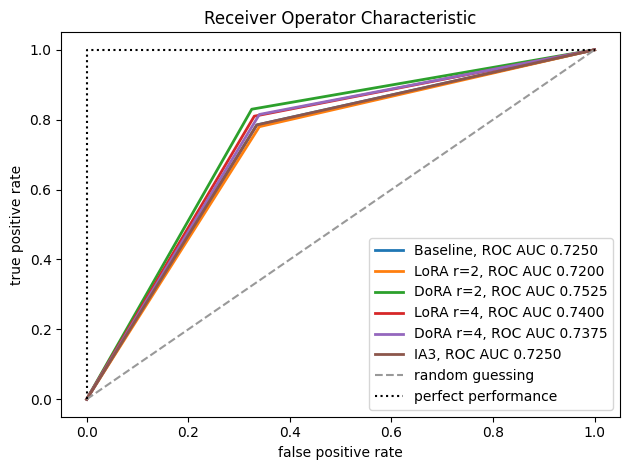

In [53]:
fpr0, tpr0, thresholds = roc_curve(test_labels, predicted_labels_baseline, pos_label = 1)
fpr1, tpr1, thresholds = roc_curve(test_labels, predicted_labels, pos_label = 1)
fpr2, tpr2, thresholds = roc_curve(test_labels, predicted_labels_dora_2, pos_label = 1)
fpr3, tpr3, thresholds = roc_curve(test_labels, predicted_labels_lora4, pos_label = 1)
fpr4, tpr4, thresholds = roc_curve(test_labels, predicted_labels_dora4, pos_label = 1)
fpr5, tpr5, thresholds = roc_curve(test_labels, predicted_labels_ia3, pos_label = 1)

# AUC score that summarizes the ROC curve
roc_auc0 = auc(fpr0, tpr0)
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
roc_auc5 = auc(fpr5, tpr5)

plt.plot(fpr0, tpr0, lw = 2, label='Baseline, ROC AUC {:.4f}'.format(roc_auc0))
plt.plot(fpr1, tpr1, lw = 2, label='LoRA r=2, ROC AUC {:.4f}'.format(roc_auc1))
plt.plot(fpr2, tpr2, lw = 2, label='DoRA r=2, ROC AUC {:.4f}'.format(roc_auc2))
plt.plot(fpr3, tpr3, lw = 2, label='LoRA r=4, ROC AUC {:.4f}'.format(roc_auc3))
plt.plot(fpr4, tpr4, lw = 2, label='DoRA r=4, ROC AUC {:.4f}'.format(roc_auc4))
plt.plot(fpr5, tpr5, lw = 2, label='IA3, ROC AUC {:.4f}'.format(roc_auc5))

plt.plot([0, 1], [0, 1],
      linestyle = '--',
      color = (0.6, 0.6, 0.6),
      label = 'random guessing')
plt.plot([0, 0, 1], [0, 1, 1],
      linestyle = ':',
      color = 'black', 
      label = 'perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

## Different LR & Accuracy Performance

In [54]:
learning_rate = 1e-2

In [55]:
baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/baseline',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=baseline_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
trainer.train()


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.031000,0.261908
2,0.096400,0.295356
3,0.022100,0.276631
4,0.140900,0.273228
5,0.083600,0.265713


ValueError: too many values to unpack (expected 2)

In [56]:
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
predicted_labels_baseline = logits.argmax(axis=-1)

sklearn_eval(test_labels,predicted_labels_baseline)

Accuracy: 0.7275
Precision: 0.7324
Recall: 0.7275
F1-Score: 0.7261
AUC ROC score: 0.7275
              precision    recall  f1-score   support

     Class 0       0.77      0.66      0.71       200
     Class 1       0.70      0.80      0.75       200

    accuracy                           0.73       400
   macro avg       0.73      0.73      0.73       400
weighted avg       0.73      0.73      0.73       400



In [59]:
lora_config = LoraConfig(
    #task_type="SEQ_CLS",
    r=2,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    lora_dropout=0.01,
)

baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)
lora_model = get_peft_model(baseline_model, lora_config)
lora_model.print_trainable_parameters()

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/dora',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
print(f'Rank: {rank}')
trainer.train()

predictions = trainer.predict(test_dataset)
loss, logits = predictions.predictions
predicted_labels_lora2 = logits.argmax(axis=-1)

sklearn_eval(test_labels, predicted_labels_lora2)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


trainable params: 285,696 || all params: 90,029,570 || trainable%: 0.3173
Rank: 2


Epoch,Training Loss,Validation Loss
1,0.710300,No log
2,0.700400,No log
3,0.708800,No log
4,0.676000,No log
5,0.712100,No log


Accuracy: 0.5000
Precision: 0.2500
Recall: 0.5000
F1-Score: 0.3333
AUC ROC score: 0.5000
              precision    recall  f1-score   support

     Class 0       0.50      1.00      0.67       200
     Class 1       0.00      0.00      0.00       200

    accuracy                           0.50       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.50      0.33       400



/data/nasif12/home_if12/l_fang/.conda/envs/dnalm_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/nasif12/home_if12/l_fang/.conda/envs/dnalm_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/nasif12/home_if12/l_fang/.conda/envs/dnalm_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [61]:
dora_config = LoraConfig(
    #task_type="SEQ_CLS",
    r=2,
    use_dora=True,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    lora_dropout=0.01,
)

baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)
dora_model = get_peft_model(baseline_model, dora_config)
dora_model.print_trainable_parameters()

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/dora',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=dora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
print(f'Rank: {rank}')
trainer.train()

predictions = trainer.predict(test_dataset)
loss, logits = predictions.predictions
predicted_labels_dora2 = logits.argmax(axis=-1)

sklearn_eval(test_labels, predicted_labels_dora2)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


trainable params: 304,128 || all params: 90,048,002 || trainable%: 0.3377
Rank: 2


Epoch,Training Loss,Validation Loss
1,0.683200,No log
2,0.680800,No log
3,0.675000,No log
4,0.698900,No log
5,0.692900,No log


Accuracy: 0.5000
Precision: 0.2500
Recall: 0.5000
F1-Score: 0.3333
AUC ROC score: 0.5000
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       200
     Class 1       0.50      1.00      0.67       200

    accuracy                           0.50       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.50      0.33       400



/data/nasif12/home_if12/l_fang/.conda/envs/dnalm_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/nasif12/home_if12/l_fang/.conda/envs/dnalm_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/nasif12/home_if12/l_fang/.conda/envs/dnalm_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [62]:
learning_rate = 1e-4

In [63]:
baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/baseline',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=baseline_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
trainer.train()
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
predicted_labels_baseline = logits.argmax(axis=-1)

sklearn_eval(test_labels,predicted_labels_baseline)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.693500,0.692649
2,0.692600,0.692861
3,0.671400,0.694236
4,0.696000,0.693101
5,0.690200,0.692831


Accuracy: 0.5000
Precision: 0.2500
Recall: 0.5000
F1-Score: 0.3333
AUC ROC score: 0.5000
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       200
     Class 1       0.50      1.00      0.67       200

    accuracy                           0.50       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.50      0.33       400



/data/nasif12/home_if12/l_fang/.conda/envs/dnalm_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/nasif12/home_if12/l_fang/.conda/envs/dnalm_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/nasif12/home_if12/l_fang/.conda/envs/dnalm_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [64]:
lora_config = LoraConfig(
    #task_type="SEQ_CLS",
    r=2,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    lora_dropout=0.01,
)

baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)
lora_model = get_peft_model(baseline_model, lora_config)
lora_model.print_trainable_parameters()

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/dora',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
print(f'Rank: {rank}')
trainer.train()

predictions = trainer.predict(test_dataset)
loss, logits = predictions.predictions
predicted_labels_lora2 = logits.argmax(axis=-1)

sklearn_eval(test_labels, predicted_labels_lora2)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


trainable params: 304,128 || all params: 90,048,002 || trainable%: 0.3377
Rank: 2


Epoch,Training Loss,Validation Loss
1,0.694800,No log
2,0.686600,No log
3,0.683800,No log
4,0.698300,No log
5,0.688900,No log


Accuracy: 0.5000
Precision: 0.2500
Recall: 0.5000
F1-Score: 0.3333
AUC ROC score: 0.5000
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       200
     Class 1       0.50      1.00      0.67       200

    accuracy                           0.50       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.50      0.33       400



/data/nasif12/home_if12/l_fang/.conda/envs/dnalm_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/nasif12/home_if12/l_fang/.conda/envs/dnalm_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/nasif12/home_if12/l_fang/.conda/envs/dnalm_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [65]:
dora_config = LoraConfig(
    #task_type="SEQ_CLS",
    r=2,
    use_dora=True,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    lora_dropout=0.01,
)

baseline_model = DNA_LM(lm, num_labels)
baseline_model.to(device)
dora_model = get_peft_model(baseline_model, dora_config)
dora_model.print_trainable_parameters()

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/dora',
    eval_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_steps=1,
    logging_steps=1,
)

# Initialize Trainer
trainer = Trainer(
    model=dora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
print(learning_rate)
trainer.train()

predictions = trainer.predict(test_dataset)
loss, logits = predictions.predictions
predicted_labels_dora2 = logits.argmax(axis=-1)

sklearn_eval(test_labels, predicted_labels_dora2)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


trainable params: 304,128 || all params: 90,048,002 || trainable%: 0.3377
0.0001


Epoch,Training Loss,Validation Loss
1,0.694900,No log
2,0.686400,No log
3,0.683900,No log
4,0.698300,No log
5,0.688800,No log


Accuracy: 0.5000
Precision: 0.2500
Recall: 0.5000
F1-Score: 0.3333
AUC ROC score: 0.5000
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       200
     Class 1       0.50      1.00      0.67       200

    accuracy                           0.50       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.50      0.33       400



/data/nasif12/home_if12/l_fang/.conda/envs/dnalm_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/nasif12/home_if12/l_fang/.conda/envs/dnalm_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/nasif12/home_if12/l_fang/.conda/envs/dnalm_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi